# Notebook Imports

In [124]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image # Pillow

%matplotlib inline

# Constants

In [131]:
EXAMPLE_FILE = 'Data/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'Data/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'Data/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'Data/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'Data/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'Data/SpamData/01_Processing/email-text-data.json'
WHALE_FILE = 'Data/SpamData/01_Processing/wordcloud_resources/whale-icon.png'

In [3]:
stream = open(EXAMPLE_FILE)
message = stream.read()
stream.close()

# print(message)

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE)

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generator_squares(N):
    for my_number in range(N):
        yield my_number**3

In [7]:
for i in generator_squares(3):
    print(i)

0
1
8


# Emails body Extractor

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for filename in filenames:
            
            filepath = join(root, filename)
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield filename, email_body

In [9]:
def df_from_directory (path, classification):
    rows = []
    row_names = []
    
    for filename, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(filename)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

In [11]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

In [12]:
print(spam_emails.shape)
print(ham_emails.shape)

(1898, 2)
(3901, 2)


In [13]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of data is:', data.shape)
data.head()


Shape of data is: (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Data Cleaning: Checking for Missing Values

In [14]:
# Check for null emails
# data.MESSAGE
data['MESSAGE'].isnull().values.any()

False

In [15]:
data['MESSAGE'].isnull().sum()

0

In [16]:
# Check if there are empty emails
(data.MESSAGE.str.len() == 0).any()

True

In [17]:
(data.MESSAGE.str.len() == 0).sum()

3

In [18]:
data[data.MESSAGE.str.len() == 0]

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [19]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Remove System File Entries from DataFrame

In [21]:
data.drop(['cmds'], inplace=True)

In [22]:
(data.MESSAGE.str.len() == 0).sum()

0

In [23]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [24]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [25]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)

data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [26]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save data to JSON file

In [27]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualized (Pie Charts)

In [28]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [29]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

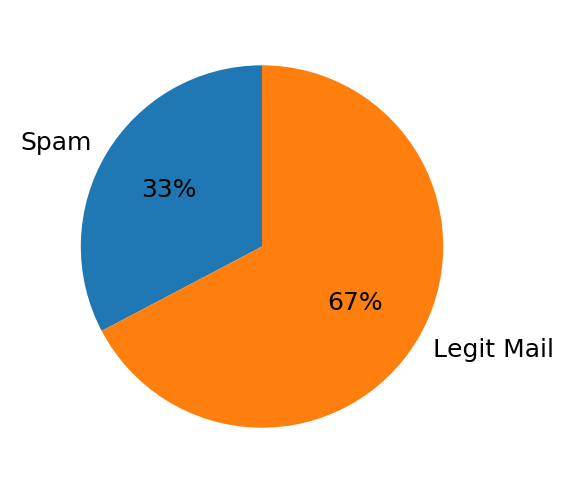

In [30]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 9}, startangle=90,
       autopct="%1.0f%%")
plt.show()

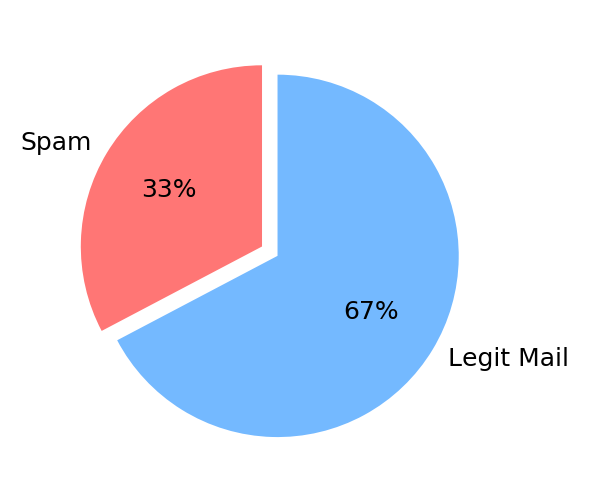

In [31]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 9}, startangle=90,
       autopct="%1.0f%%", colors=custom_colours, explode=[0, 0.1])
plt.show()

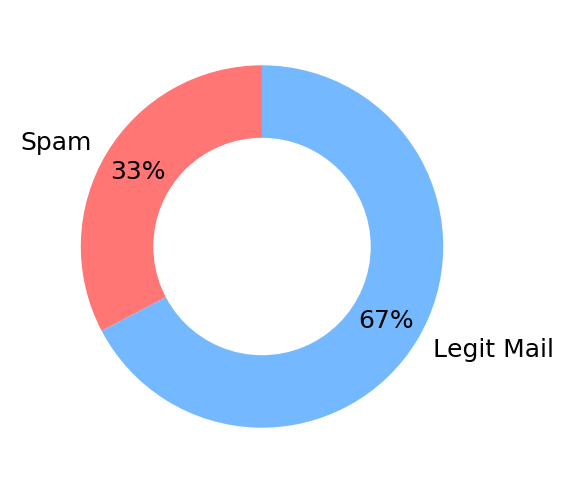

In [32]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 9}, startangle=90,
       autopct="%1.0f%%", colors=custom_colours, pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()


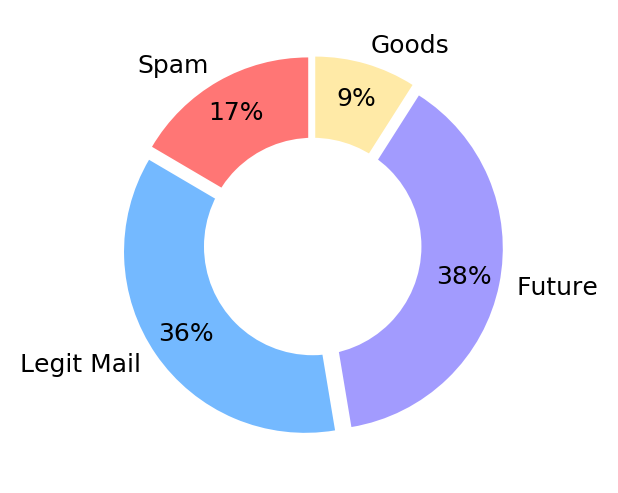

In [33]:
category_names = ['Spam', 'Legit Mail', 'Future', 'Goods']
sizes = [22, 48, 51, 12]
custom_colours = ['#ff7675', '#74b9ff', '#a29bfe', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 9}, startangle=90,
       autopct="%1.0f%%", colors=custom_colours, pctdistance=0.8, explode=offset)

#draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()


# Natural Language Processing

### Text Pre-Processing

In [34]:
# convert to lowercase
msg = 'I am the Bond of my Swords'
msg.lower()

'i am the bond of my swords'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vinh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vinh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Vinh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Vinh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\shakespeare.zip.


True

### Tokenising

In [37]:
msg = 'I am the Bond of my Swords'
word_tokenize(msg.lower())

['i', 'am', 'the', 'bond', 'of', 'my', 'swords']

### Removing Stopwords

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
type(stopwords.words('english'))

list

In [40]:
type(stop_words)

set

In [41]:
if 'alll' not in stop_words: 
    print('Nope')

Nope


In [42]:
if 'all' in stop_words: 
    print('Ok')

Ok


In [43]:
msg = 'I am the Bond of my Swords. Let it be'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['bond', 'swords', '.', 'let']


### Word Stemming

In [44]:
msg = 'I am the Bond of my Swords. Steel is my body. Let it be'
words = word_tokenize(msg.lower())
stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['bond', 'sword', '.', 'steel', 'bodi', '.', 'let']


### Removing Punctuation

In [45]:
'a'.isalpha()

True

In [46]:
'?'.isalpha()

False

In [47]:
msg = 'I am the Bond of my Swords. Steel is my body. Let it be???'
words = word_tokenize(msg.lower())
stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['bond', 'sword', 'steel', 'bodi', 'let']


### Removing HTML Tags

In [48]:
soup = BeautifulSoup(data.at[7, 'MESSAGE'], 'html.parser') #better view
print(soup.prettify())

<html>
 <head>
  <title>
   ReliaQuote - Save Up To 70% On Life Insurance
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
 </head>
 <body alink="#FFCC00" leftmargin="0" link="#FFCC99" topmargin="0" vlink="#FFCC99">
  <table align="center" bgcolor="993366" border="0" cellpadding="0" cellspacing="0" height="500" width="468">
   <tr>
    <td align="left" height="43" valign="top" width="56%">
     <table border="0" cellpadding="3" cellspacing="0" width="100%">
      <tr>
       <td>
        <a href="http://theadmanager.com/server/c.asp?ad_key=YUESBHWAKMLK&amp;ext=1" target="_blank">
         <img border="0" height="32" src="http://www.reliaquote.com/banner/bannerads/images/logo6.gif" width="120"/>
        </a>
       </td>
      </tr>
     </table>
    </td>
    <td align="left" height="43" valign="top" width="44%">
    </td>
   </tr>
   <tr>
    <td align="left" height="377" valign="top" width="56%">
     <table border="0" cellpadding="0" cellspacing="0" 

In [49]:
soup.get_text() #remove html tags

"\n\nReliaQuote - Save Up To 70% On Life Insurance\n\n\n\n\n\n\n\n\n\n\n\n\n\xa0\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLife\n\n                                can change in an instant. That's why it is so\n\n                                important to protect your family's financial future\n\n                                with sufficient life insurance coverage.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nState\n\n                          of Residence:\n\n\n\nSelect State\nAlabama\nAlaska\nArizona\nArkansas\nCalifornia\nColorado\nConnecticut\nDelaware\nDist. of Columbia\nFlorida\nGeorgia\nHawaii\nIdaho\nIllinois\nIndiana\nIowa\nKansas\nKentucky\nLouisiana\nMaine\nMaryland\nMassachusetts\nMichigan\nMinnesota\nMississippi\nMissouri\nMontana\nNebraska\nNevada\nNew Hampshire\nNew Jersey\nNew Mexico\nNew York\nNorth Carolina\nNorth Dakota\nOhio\nOklahoma\nOregon\nPennsylvania\nRhode Island\nSouth Carolina\nSouth Dakota\nTennessee\nTexas\nUtah\nVermont\nVirginia\nWashington\nWest V

## Functions for Email Processing

In [50]:
def clean_message(message, stop_words = set(stopwords.words('english')),
                 stemmer = PorterStemmer()):
    filtered_word = []
    words = word_tokenize(message.lower())
    
    for word in words:
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_word.append(stemmed_word)
    
    return filtered_word

In [51]:
clean_message(data.at[7, 'MESSAGE'])

['html',
 'head',
 'titl',
 'reliaquot',
 'save',
 'life',
 'insur',
 'meta',
 'bodi',
 'tabl',
 'center',
 'tr',
 'td',
 'left',
 'top',
 'tabl',
 'tr',
 'td',
 'http',
 'img',
 'http',
 'td',
 'left',
 'top',
 'nbsp',
 'tr',
 'td',
 'left',
 'top',
 'tabl',
 'tr',
 'right',
 'top',
 'ffccff',
 'td',
 'img',
 'http',
 'tr',
 'center',
 'top',
 'td',
 'tabl',
 'tr',
 'center',
 'top',
 'td',
 'tabl',
 'tr',
 'left',
 'top',
 'td',
 'tabl',
 'tr',
 'center',
 'top',
 'td',
 'p',
 'font',
 'tahoma',
 'verdana',
 'arial',
 'b',
 'life',
 'chang',
 'instant',
 'import',
 'protect',
 'famili',
 'financi',
 'futur',
 'suffici',
 'life',
 'insur',
 'tr',
 'center',
 'middl',
 'td',
 'font',
 'b',
 'img',
 'http',
 'tr',
 'left',
 'top',
 'td',
 'form',
 'http',
 'get',
 'input',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'tahoma',
 'verdana',
 'arial',
 'ffffff',
 'strong',
 'state',
 'resid',
 'td',
 'left',
 'middl',
 'font',
 'tahoma',
 'verdana',
 'arial',

In [52]:
def clean_message_no_html(message, stop_words = set(stopwords.words('english')),
                 stemmer = PorterStemmer()):
    filtered_word = []
    
    # clean html text
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    
    for word in words:
        # remove stopwords and punctuation
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word) 
            filtered_word.append(stemmed_word)
    
    return filtered_word

In [53]:
clean_message_no_html(data.at[7, 'MESSAGE'])

['reliaquot',
 'save',
 'life',
 'insur',
 'life',
 'chang',
 'instant',
 'import',
 'protect',
 'famili',
 'financi',
 'futur',
 'suffici',
 'life',
 'insur',
 'coverag',
 'state',
 'resid',
 'select',
 'state',
 'alabama',
 'alaska',
 'arizona',
 'arkansa',
 'california',
 'colorado',
 'connecticut',
 'delawar',
 'dist',
 'columbia',
 'florida',
 'georgia',
 'hawaii',
 'idaho',
 'illinoi',
 'indiana',
 'iowa',
 'kansa',
 'kentucki',
 'louisiana',
 'main',
 'maryland',
 'massachusett',
 'michigan',
 'minnesota',
 'mississippi',
 'missouri',
 'montana',
 'nebraska',
 'nevada',
 'new',
 'hampshir',
 'new',
 'jersey',
 'new',
 'mexico',
 'new',
 'york',
 'north',
 'carolina',
 'north',
 'dakota',
 'ohio',
 'oklahoma',
 'oregon',
 'pennsylvania',
 'rhode',
 'island',
 'south',
 'carolina',
 'south',
 'dakota',
 'tennesse',
 'texa',
 'utah',
 'vermont',
 'virginia',
 'washington',
 'west',
 'virginia',
 'wisconsin',
 'wyom',
 'date',
 'birth',
 'mm',
 'dd',
 'yy',
 'sex',
 'male',
 'femal'

In [54]:
len(clean_message(data.at[7, 'MESSAGE']))

733

In [55]:
len(clean_message_no_html(data.at[7, 'MESSAGE']))

162

# Apply Cleaning and Tokenisation for all emails

### Slicing Dataframes and Series & Creating Subsets

In [56]:
data.iat[2, 1]

1

In [57]:
data.iloc[5:9]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab


In [58]:
data.MESSAGE.iloc[0:3]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

In [59]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message_no_html)

In [60]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

192

In [61]:
flat_list

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [62]:
type(flat_list)

list

In [63]:
%%time

# use apply() to all the messages in dataframe
nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\Vinh\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 53.3 s


In [64]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

### Using logic to slice Dataframes

In [65]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [66]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [67]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting Series with index

In [68]:
type(nested_list)

pandas.core.series.Series

In [69]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [70]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [71]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0] #number of unique words in non-spam message

20755

In [72]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [73]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0] #number of unique words in non-spam message

13284

In [74]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

### Creating a Word Cloud

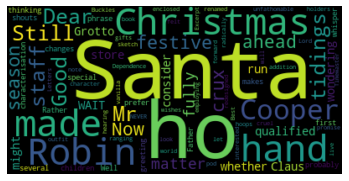

In [86]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [92]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [95]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [109]:
word_list = [''.join(word) for word in example_corpus] # from token to listed words
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

In [105]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [104]:
word_list

['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

In [106]:
type(word_list)

list

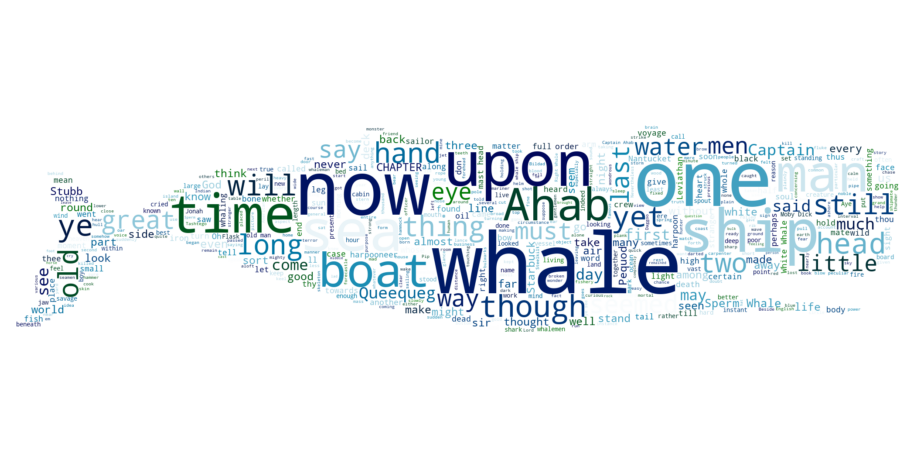

In [130]:
plt.figure(figsize=(16, 10))

icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=500, colormap='ocean')
word_cloud.generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [148]:
shakespeare_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [word for word in shakespeare_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

"[ The Tragedie of Hamlet by William Shakespeare 1599 ] Actus Primus . Scoena Prima . Enter Barnardo and Francisco two Centinels . Barnardo . Who ' s there ? Fran . Nay answer me : Stand & vnfold your selfe Bar . Long liue the King Fran . Barnardo ? Bar . He Fran . You come most carefully vpon your houre Bar . ' Tis now strook twelue , get thee to bed Francisco Fran . For this releefe much thankes : ' Tis bitter cold , And I am sicke at heart Barn . Haue you had quiet Guard ? Fran . Not a Mouse stirring Barn . Well , goodnight . If you do meet Horatio and Marcellus , the Riuals of my Watch , bid them make hast . Enter Horatio and Marcellus . Fran . I thinke I heare them . Stand : who ' s there ? Hor . Friends to this ground Mar . And Leige - men to the Dane Fran . Giue you good night Mar . O farwel honest Soldier , who hath relieu ' d you ? Fra . Barnardo ha ' s my place : giue you goodnight . Exit Fran . Mar . Holla Barnardo Bar . Say , what is Horatio there ? Hor . A peece of him Bar

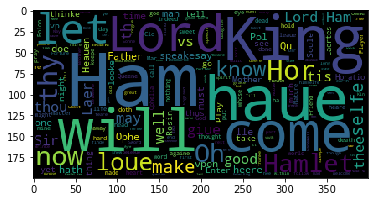

In [152]:
word_cloud = WordCloud().generate(novel_as_string)
plt.imshow(word_cloud)
plt.show()